In [4]:


import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]



     


2022-12-07 08:26:22.385922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 08:26:22.524891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-07 08:26:22.524912: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-07 08:26:23.295394: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [5]:


df = pd.read_csv("creditcard.csv")



     


In [6]:


df.isnull().values.any()



     


False

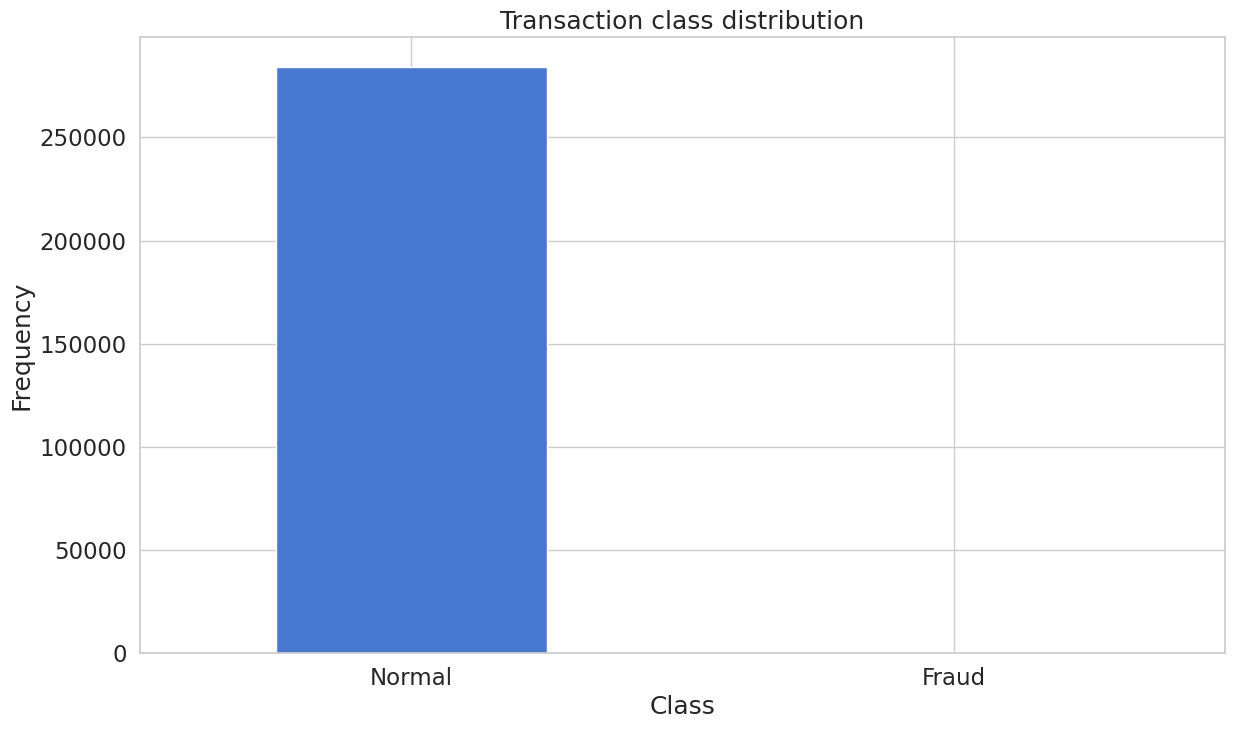

In [7]:


count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");



     


In [8]:


frauds = df[df.Class == 1]
normal = df[df.Class == 0]



     


frauds.shape



     


(492, 31)

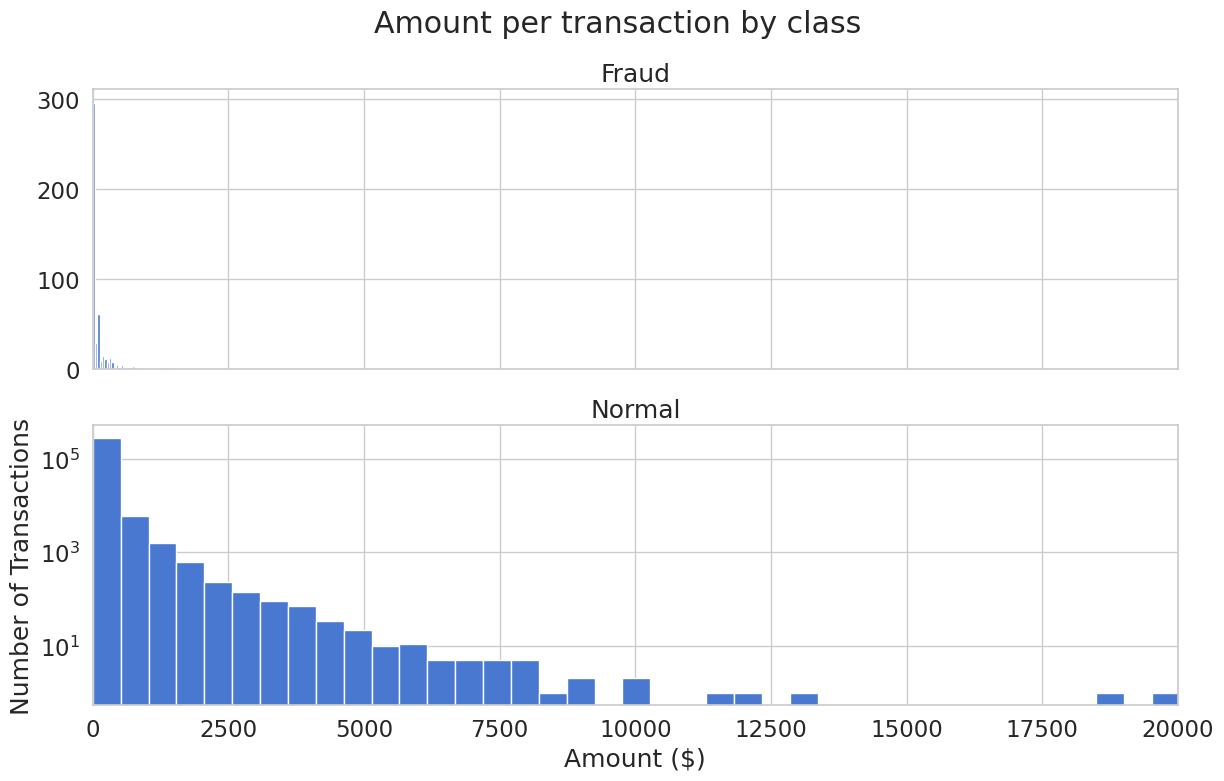

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

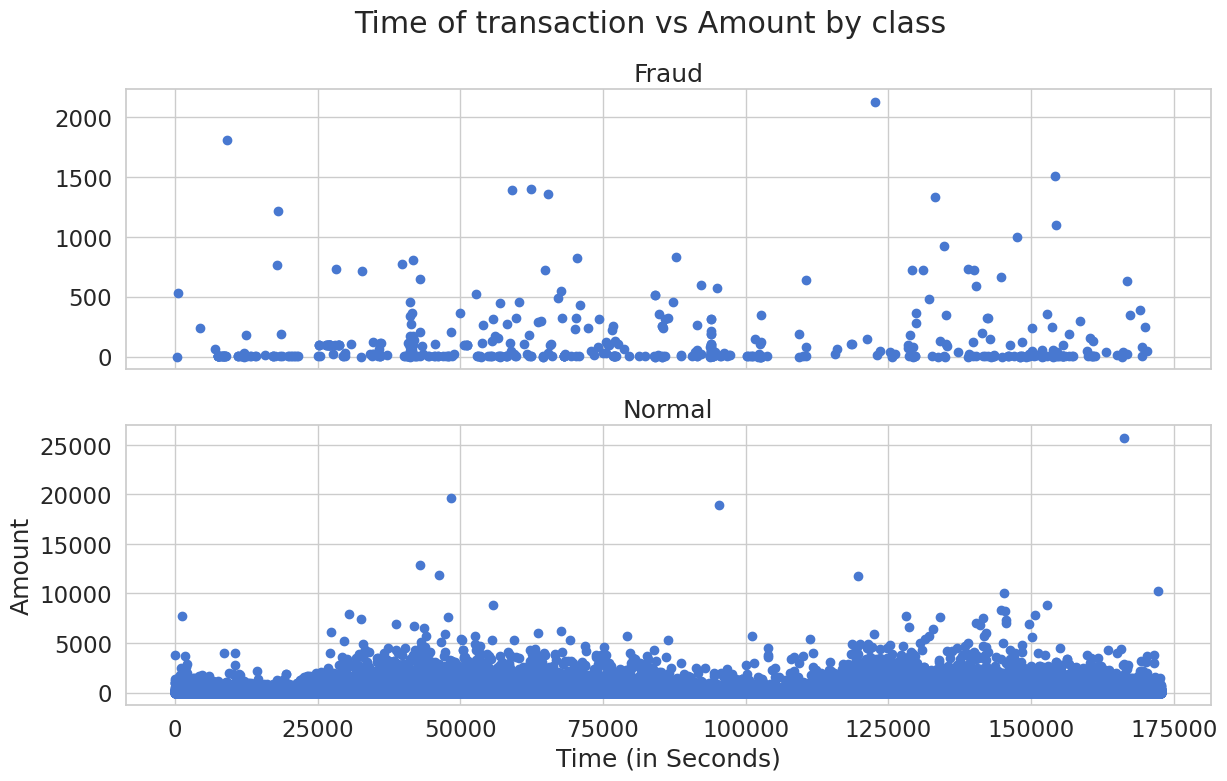

In [10]:


f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()



     


In [11]:


from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))



     


In [12]:


X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

X_train, X_final = train_test_split(X_train, test_size=0.2, random_state=RANDOM_SEED)

y_train = X_train['Class']
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

y_final= X_final['Class']
X_final = X_final.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values
X_final = X_final.values



     


In [13]:


input_dim = X_train.shape[1]
encoding_dim = 14



     


In [14]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

2022-12-07 08:26:28.830059: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-07 08:26:28.830100: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-07 08:26:28.830135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jack-GE63VR-7RF): /proc/driver/nvidia/version does not exist
2022-12-07 08:26:28.830413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:


nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history



     


Epoch 1/10
5697/5697 [==============================] - 11s 2ms/step - loss: 0.8743 - accuracy: 0.5797 - val_loss: 0.7999 - val_accuracy: 0.6318
Epoch 2/10
5697/5697 [==============================] - 10s 2ms/step - loss: 0.8118 - accuracy: 0.6461 - val_loss: 0.7792 - val_accuracy: 0.6646
Epoch 3/10
5697/5697 [==============================] - 10s 2ms/step - loss: 0.7956 - accuracy: 0.6707 - val_loss: 0.7704 - val_accuracy: 0.6768
Epoch 4/10
5697/5697 [==============================] - 10s 2ms/step - loss: 0.7886 - accuracy: 0.6746 - val_loss: 0.7650 - val_accuracy: 0.6772
Epoch 5/10
5697/5697 [==============================] - 11s 2ms/step - loss: 0.7832 - accuracy: 0.6746 - val_loss: 0.7621 - val_accuracy: 0.6709
Epoch 6/10
5697/5697 [==============================] - 11s 2ms/step - loss: 0.7803 - accuracy: 0.6755 - val_loss: 0.7586 - val_accuracy: 0.6720
Epoch 7/10
5697/5697 [==============================] - 11s 2ms/step - loss: 0.7781 - accuracy: 0.6765 - val_loss: 0.7573 - val_ac

In [16]:


autoencoder = load_model('model.h5')



     


evaluation

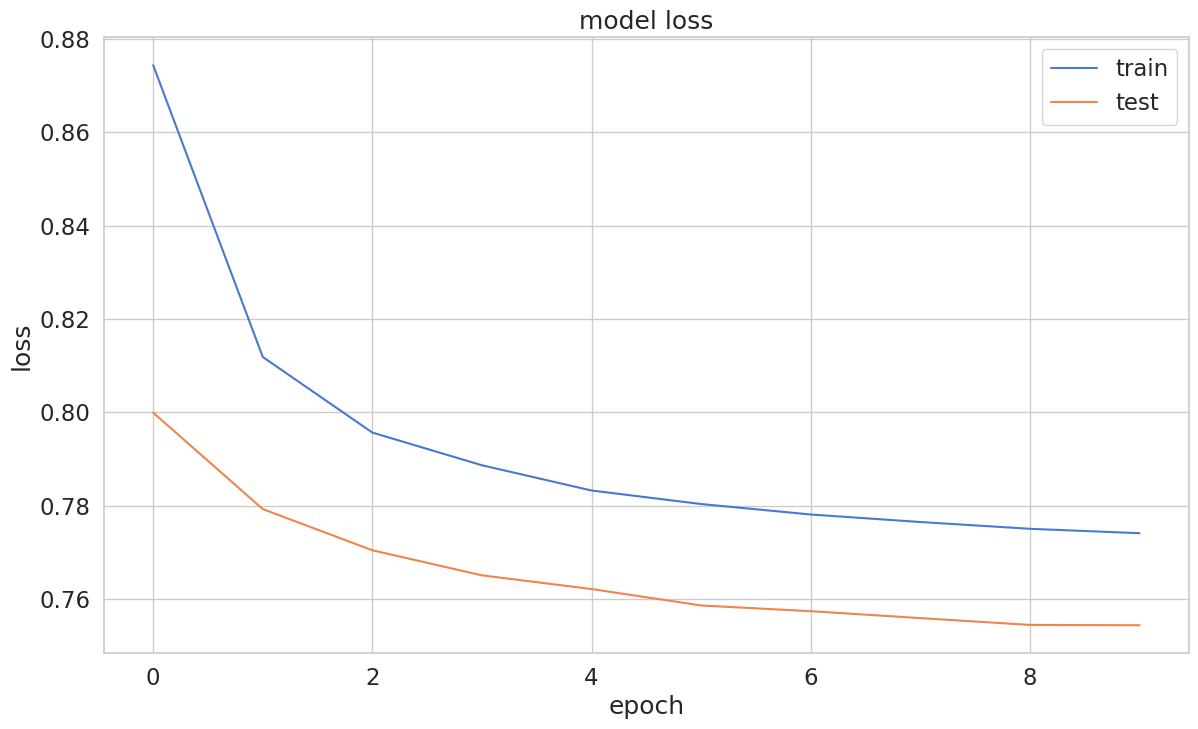

In [17]:


plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');



     


In [18]:


predictions = autoencoder.predict(X_test)



     


1781/1781 [==============================] - 2s 934us/step


In [19]:


mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})



     


In [20]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

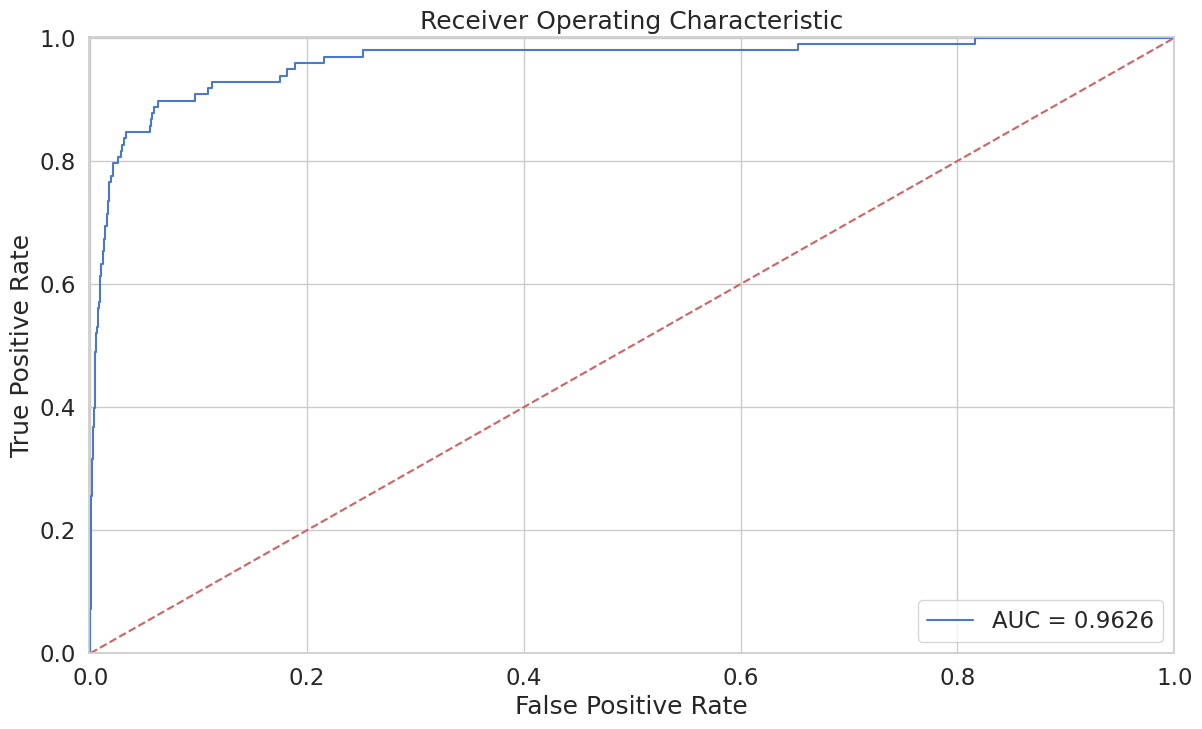

In [21]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

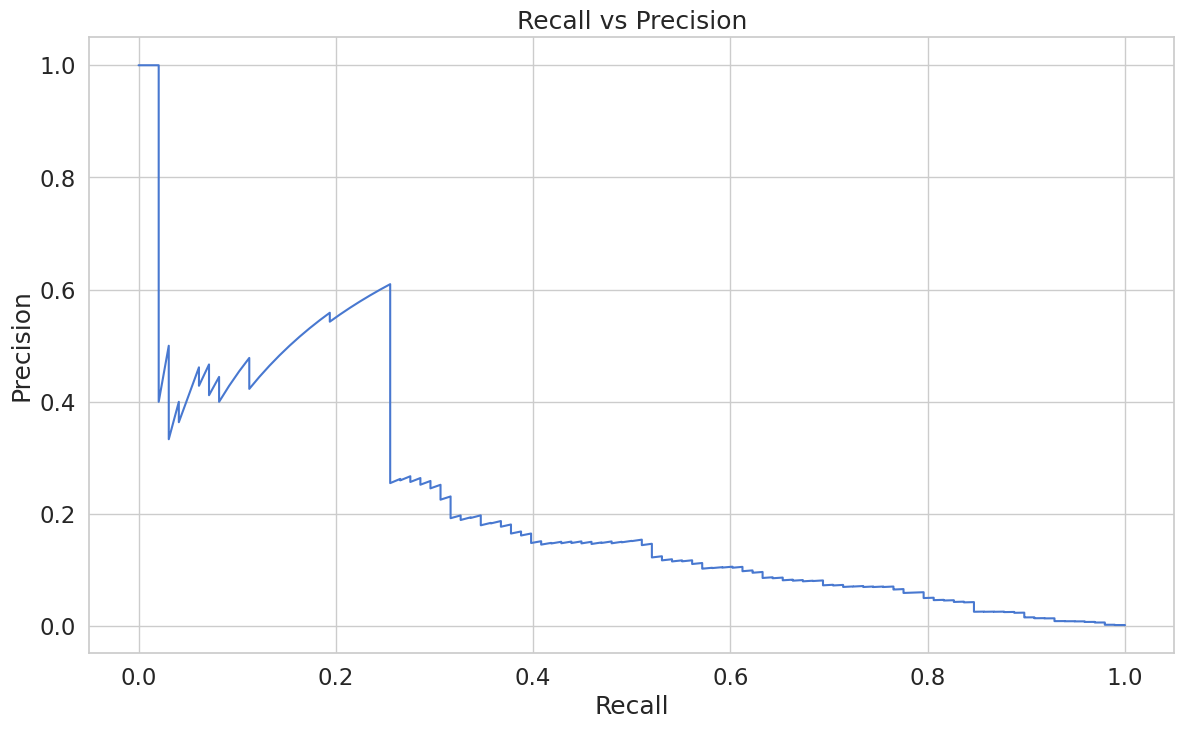

In [22]:


precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()



     


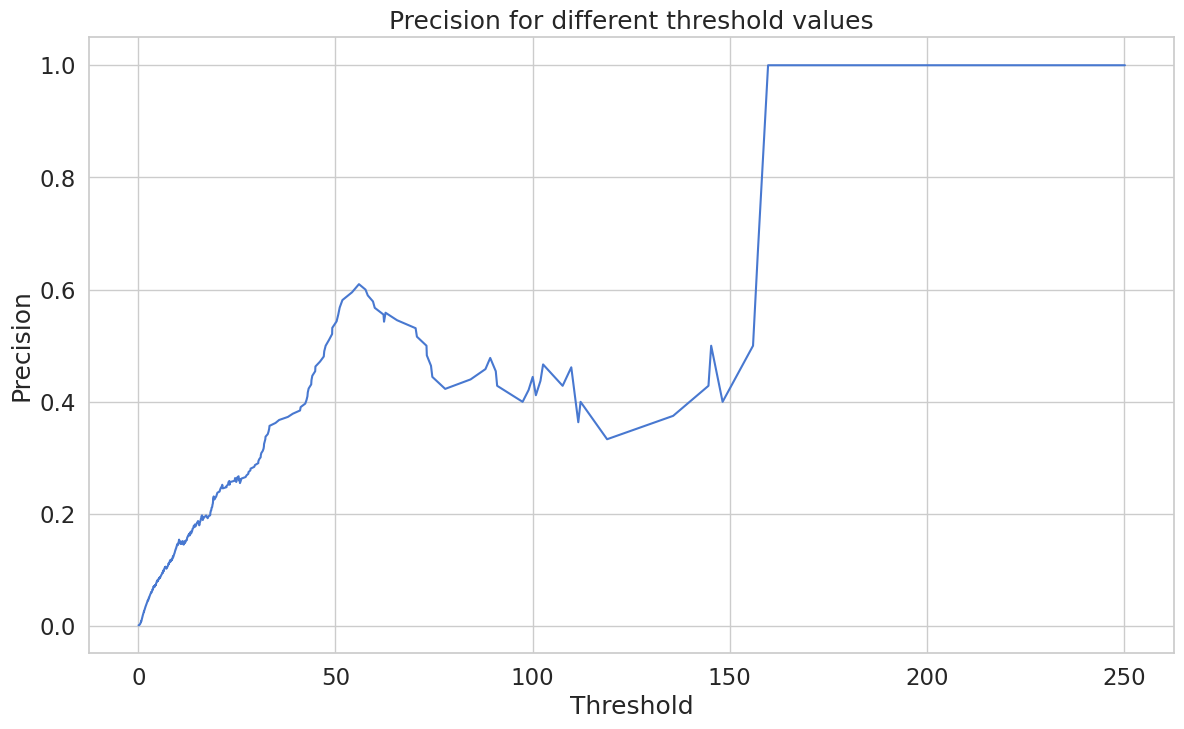

In [23]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

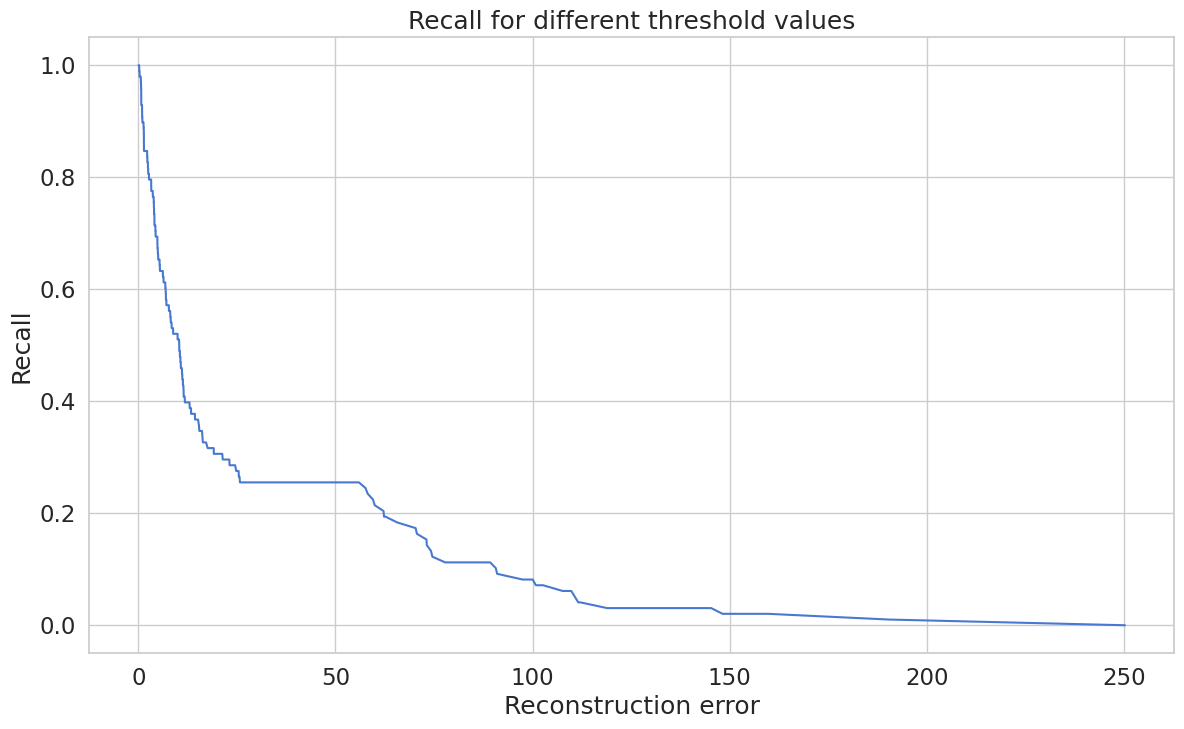

In [24]:


plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()



     


In [25]:


threshold = 2.9



     


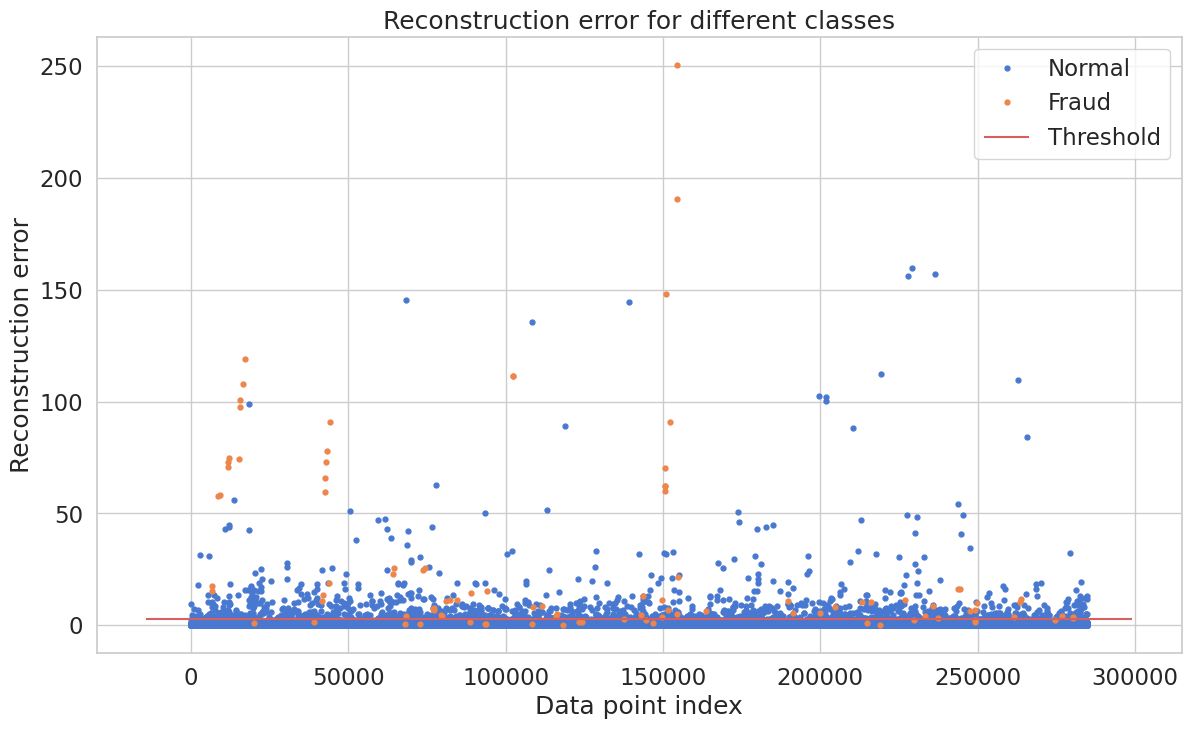

In [26]:


groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();



     


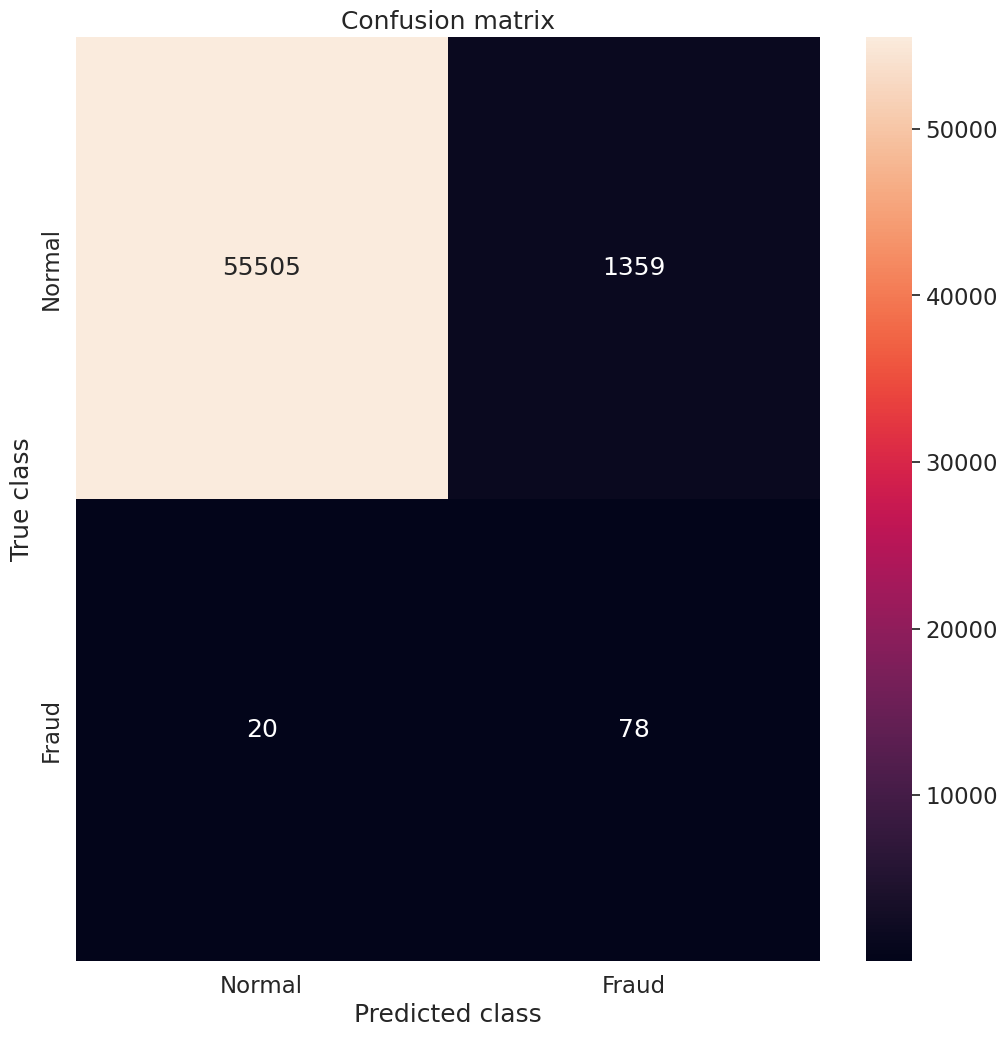

In [27]:


y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



     


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [29]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.975791
Precision: 0.054280
Recall: 0.795918
F1 score: 0.101629


for comparison purpose

In [30]:
predictions_f = autoencoder.predict(X_final)


1425/1425 [==============================] - 2s 1ms/step


In [31]:
mse_f = np.mean(np.power(X_final - predictions_f, 2), axis=1)
error_df_f = pd.DataFrame({'reconstruction_error': mse_f,
                        'true_class': y_final})

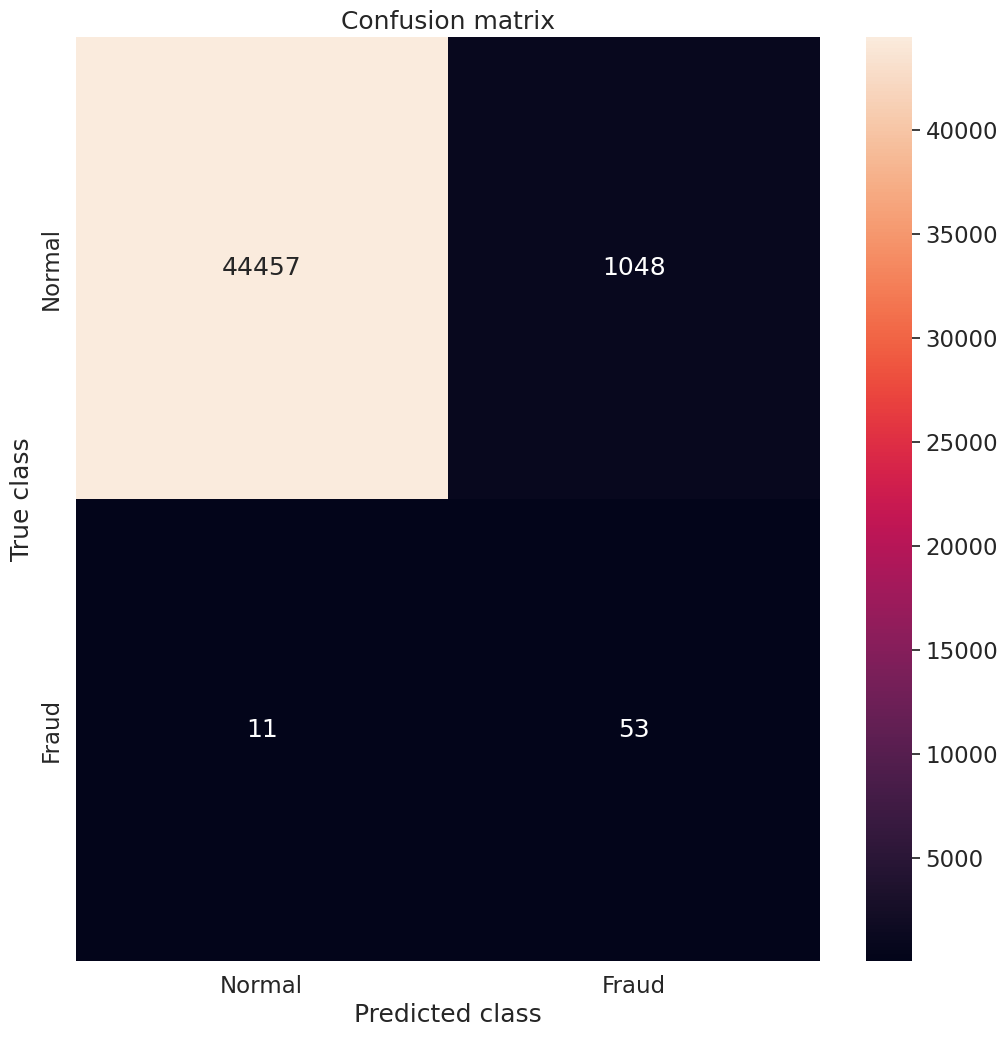

In [32]:
y_pred_f = [1 if e > threshold else 0 for e in error_df_f.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_f.true_class, y_pred_f)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [34]:
accuracy = accuracy_score(y_final, y_pred_f)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_final, y_pred_f)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_final, y_pred_f)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_final, y_pred_f)
print('F1 score: %f' % f1)

Accuracy: 0.976761
Precision: 0.048138
Recall: 0.828125
F1 score: 0.090987


supervised learning xgboost

In [35]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import pandas as pd
import numpy as np

In [38]:
xgboost = XGBClassifier(learning_rate =0.05,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 
 nthread=4,
 scale_pos_weight=1,
 seed=27).fit(X_train, y_train)

print('Cross Validation for XGBClassifier')
print(xgboost.score(X_test, y_test))



Cross Validation for XGBClassifier
0.9996488887328394


In [48]:
y_pred_xgb = xgboost.predict(X_test)

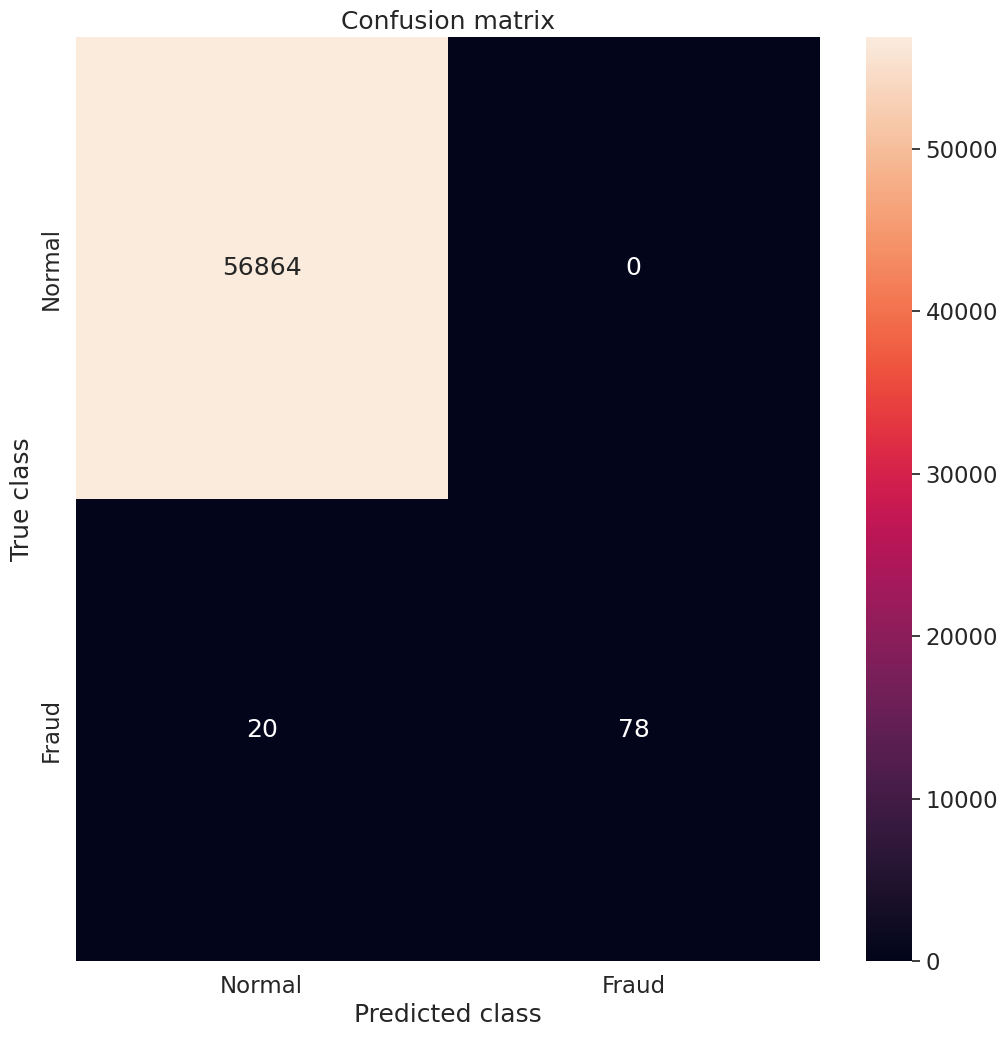

In [49]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_xgb)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_xgb)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_xgb)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_xgb)
print('F1 score: %f' % f1)

Accuracy: 0.999649
Precision: 1.000000
Recall: 0.795918
F1 score: 0.886364


In [52]:
y_pred_f_xgb = xgboost.predict(X_final)

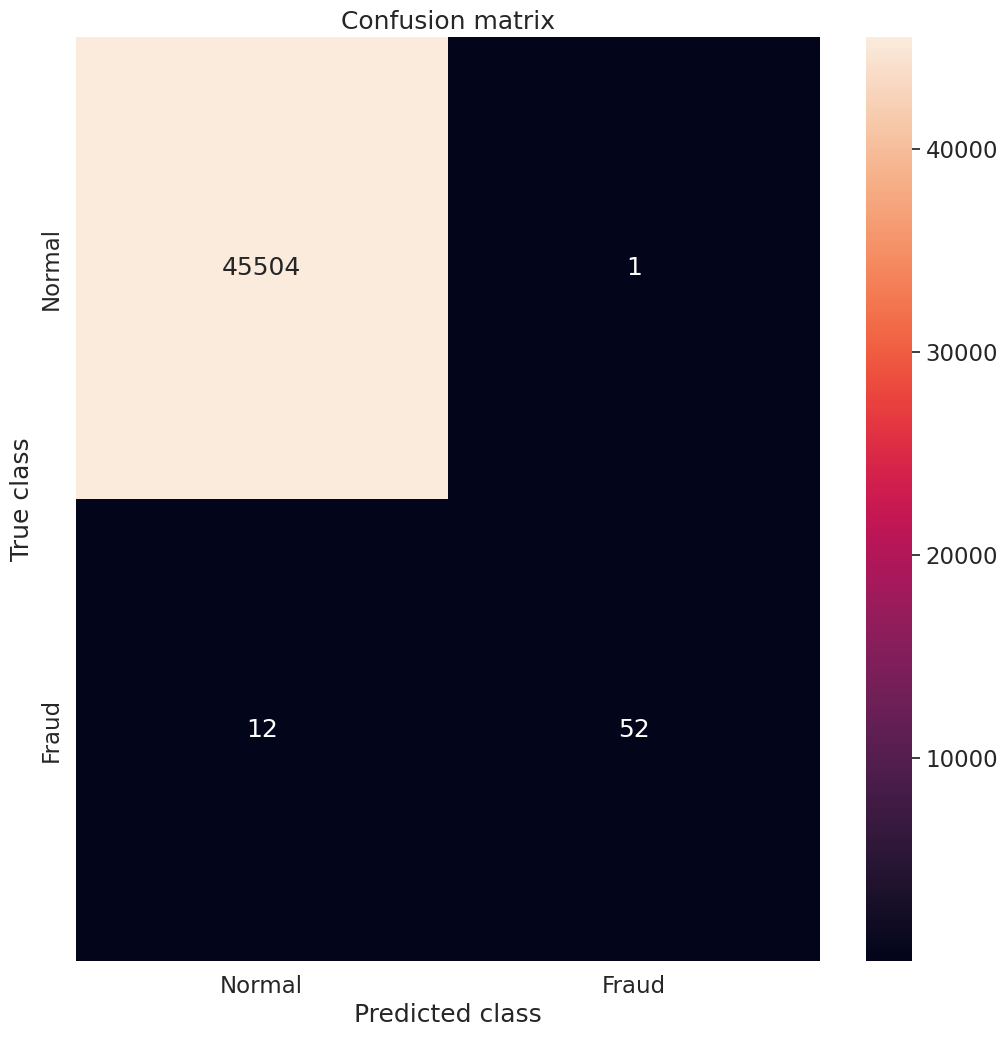

In [54]:
conf_matrix = confusion_matrix(y_final, y_pred_f_xgb)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [53]:
accuracy = accuracy_score(y_final, y_pred_f_xgb)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_final, y_pred_f_xgb)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_final, y_pred_f_xgb)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_final, y_pred_f_xgb)
print('F1 score: %f' % f1)

Accuracy: 0.999715
Precision: 0.981132
Recall: 0.812500
F1 score: 0.888889
